In [1]:
import chainer
from chainer import Function,Link, Chain, ChainList, Variable, optimizers, iterators
from chainer import function_node
import chainer.functions as F 
import chainer.links as L 
from chainer import cuda
from chainer import initializers
from chainer import serializers
import numpy as np
from chainer.cuda import cupy as cp

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_path(ax, path,color='blue', xlim=[.0,2.],ylim=[-1.0,1.0]):
    for i in range(1,len(path)):
        ax.quiver(path[i-1,0],path[i-1,1]
                   , path[i,0]-path[i-1,0],path[i,1]-path[i-1,1]
                   , scale_units='xy', angles='xy', scale=1,color=color)
    ax.set_xlabel("x[m]")
    ax.set_ylabel("y[m]")
    ax.axis('scaled')
    ax.grid()
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

In [3]:
def perturbation(shape, sigma=0.01):
    R, dim = shape
    mu_arr = np.zeros(dim,dtype=np.float32)
    sigma_arr = np.eye((dim),dtype=np.float32) * sigma **2
    ret = np.random.multivariate_normal(mu_arr,sigma_arr,R).astype(np.float32)
    return ret

class Oplus_NES(function_node.FunctionNode):
    def motion_update(self, t1, t2):
        cos1 = np.cos(t1[2])
        sin1 = np.sin(t1[2])
        x = cos1 * t2[0] - sin1 * t2[1] + t1[0]
        y = sin1 * t2[0] + cos1 * t2[1] + t1[1]
        t = ( t1[2] + t2[2] + np.pi) % (2 * np.pi ) - np.pi
        ret = np.array([x,y,t], dtype=t1.dtype)
        return ret
        
    def forward_cpu(self, inputs):
        t1, t2 = inputs
        self.R = 1
        self.sigma = .01
        self.p = perturbation((self.R,2),sigma=self.sigma)
        t1_up = t1 + self.p[:,0]
        t1_down = t1 - self.p[:,0]
        t2_up = t2 + self.p[:,1]
        t2_down = t2 - self.p[:,1]
        y_up = self.motion_update(t1_up, t2_up)
        y_down = self.motion_update(t1_down, t2_down)        
        ret = np.array([y_up, y_down],dtype=np.float32)
        #print('ret:' + str(ret))
        self.retain_inputs([0,1])
        self.retain_outputs([0])
        return ret ,

    def forward_gpu(self, inputs):
        t1, t2 = inputs
        self.R = 1
        self.sigma = .01
        self.p = cp.asarray(perturbation((self.R,2),sigma=self.sigma))
        t1_up = t1 + self.p[:,0]
        t1_down = t1 - self.p[:,0]
        t2_up = t1 + self.p[:,1]
        t2_down = t1 - self.p[:,1]
        y_up = cp.asarray(self.motion_update(t1_up, t2_up))
        y_down = cp.asarray(self.motion_update(t1_down, t2_down))
        ret = cp.array([y_up, y_down],dtype=cp.float32)
        #print('ret:' + str(ret))
        self.retain_inputs([0])
        self.retain_outputs([0])
        return ret,
    
    def backward(self, inputs, grad_outputs):
        gy, = grad_outputs
        t1, t2 = self.get_retained_inputs()
        t1 = np.array(t1.data,dtype=np.float32)
        t2 = np.array(t2.data,dtype=np.float32)
        Y_up, Y_down = self.get_retained_outputs()[0]
        Y_up = np.array(Y_up.data, dtype=np.float32)
        Y_down = np.array(Y_down.data, dtype=np.float32)
        D = Y_up - Y_down
        dt1 = D * self.p[:,0] * 0.5 / (self.sigma**2 * self.R)
        gt1_up = gy[0] * dt1
        gt1_down = gy[1] * dt1
        gt1 = gt1_up + gt1_down
        dt2 = D * self.p[:,1] * 0.5 / (self.sigma**2 * self.R)
        gt2_up = gy[0] * dt2
        gt2_down = gy[1] * dt2
        gt2 = gt2_up + gt2_down
        return gt1,gt2
        
def oplus_nes(z,y):
    return Oplus_NES().apply((z,y))[0]

[[0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [4.9961966e-01 3.3578277e-04 0.0000000e+00]
 [9.9962831e-01 2.7082954e-04 0.0000000e+00]
 [1.4995143e+00 3.6653318e-04 0.0000000e+00]]


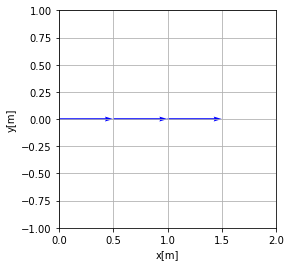

In [4]:
x1 = Variable(np.array([.0, .0, .0], dtype=np.float32))
x2 = Variable(np.array([.5, .0, .0], dtype=np.float32))
x3 = Variable(np.array([.5, .0, .0], dtype=np.float32))
x4 = Variable(np.array([.5, .0, .0], dtype=np.float32))

z1 = oplus_nes(x1, x2)
mz1 = (z1[0] + z1[1]) *.5
z2 = oplus_nes(mz1, x3)
mz2 = (z2[0] + z2[1]) *.5
z3 = oplus_nes(mz2, x4)
mz3 = (z3[0] + z3[1]) *.5
z = F.stack([x1, mz1, mz2, mz3])
print(z.data)
fig, ax = (plt.figure(), plt.axes())
plot_path(ax, z.data)
plt.show()

z=
variable([[0.         0.         0.3       ]
          [0.47767    0.14775428 0.6       ]
          [0.8903196  0.43007836 0.90000004]
          [1.2010078  0.82171303 1.2       ]])
xt=
[[ 0.0000000e+00  0.0000000e+00  0.0000000e+00]
 [ 5.0000620e-01 -7.1761897e-06  0.0000000e+00]
 [ 1.0000734e+00 -1.0347902e-04  0.0000000e+00]
 [ 1.4998679e+00  8.4741041e-05  0.0000000e+00]]
error
variable(3.683825)
variable([-0.01191353  0.36393702  0.9851169 ])
variable([ 0.0029694  -0.09070986 -0.09598885])
variable([-0.10001038  3.7510648   3.4320633 ])
variable([-0.20678857  3.0320327   3.2703018 ])


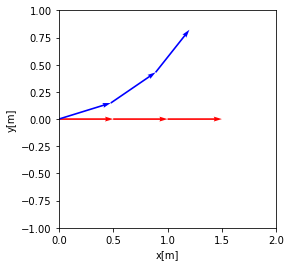

In [5]:
def Error(xt, x):
    e = F.sum((xt - x)**2)
    return e

xt = np.array([
    [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
    [ 5.0000620e-01, -7.1761897e-06,  0.0000000e+00],
    [ 1.0000734e+00, -1.0347902e-04,  0.0000000e+00],
    [ 1.4998679e+00,  8.4741041e-05,  0.0000000e+00]]
    )
x1 = Variable(np.array([.0, .0, .3], dtype=np.float32))
x2 = Variable(np.array([.5, .0, .3], dtype=np.float32))
x3 = Variable(np.array([.5, .0, .3], dtype=np.float32))
x4 = Variable(np.array([.5, .0, .3], dtype=np.float32))
z1 = oplus_nes(x1, x2)
mz1 = (z1[0] + z1[1]) *.5
z2 = oplus_nes(mz1, x3)
mz2 = (z2[0] + z2[1]) *.5
z3 = oplus_nes(mz2, x4)
mz3 = (z3[0] + z3[1]) *.5
z = F.stack([x1, mz1, mz2, mz3])
print('z=')
print(z)
print('xt=')
print(xt)
e = Error(z,xt)
print('error')
print(e)
e.backward()
gx1 = chainer.grad((e,),(x1,))[0]
gx2 = chainer.grad((e,),(x2,))[0]
gx3 = chainer.grad((e,),(x3,))[0]
gx4 = chainer.grad((e,),(x4,))[0]
print(gx1)
print(gx2)
print(gx3)
print(gx4)

fig, ax = (plt.figure(), plt.axes())
plot_path(ax, xt, color='red')
plot_path(ax, z.data, color='blue')
plt.show()

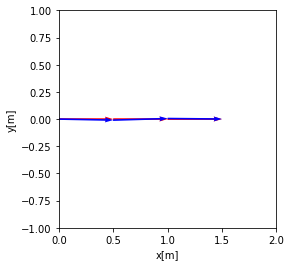

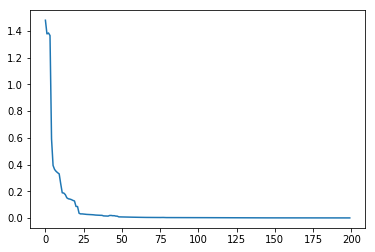

In [6]:
itr = 200
lr = .01
loss = []

xt = np.array([
    [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
    [ 5.0000620e-01, -7.1761897e-06,  0.0000000e+00],
    [ 1.0000734e+00, -1.0347902e-04,  0.0000000e+00],
    [ 1.4998679e+00,  8.4741041e-05,  0.0000000e+00]])
x1 = Variable(np.array([.0, .0, .0], dtype=np.float32))
x2 = Variable(np.array([.5, .0, .3], dtype=np.float32))
x3 = Variable(np.array([.5, .0, .3], dtype=np.float32))
x4 = Variable(np.array([.5, .0, .3], dtype=np.float32))
for i in range(itr):
    z1 = oplus_nes(x1, x2)
    mz1 = (z1[0] + z1[1]) *.5
    z2 = oplus_nes(mz1, x3)
    mz2 = (z2[0] + z2[1]) *.5
    z3 = oplus_nes(mz2, x4)
    mz3 = (z3[0] + z3[1]) *.5
    z = F.stack([x1, mz1, mz2, mz3])
    e = Error(z,xt)
    e.backward()
    loss.append(e.data)
    gx1 = chainer.grad((e,),(x1,))[0]
    gx2 = chainer.grad((e,),(x2,))[0]
    gx3 = chainer.grad((e,),(x3,))[0]
    gx4 = chainer.grad((e,),(x4,))[0]
    #x1 = Variable(x1.data - lr*gx1.data)
    x2 = Variable(x2.data - lr*gx2.data)
    x3 = Variable(x3.data - lr*gx3.data)
    x4 = Variable(x4.data - lr*gx4.data)


fig, ax = (plt.figure(), plt.axes())
plot_path(ax, xt, color='red')
plot_path(ax, z.data, color='blue')
plt.show()
plt.plot(range(len(loss)),loss)

In [7]:
class Simulator_Oplus_NES(function_node.FunctionNode):
    def padding(self,v,w):
        pad = np.zeros((1,len(v[0])),dtype=v.dtype)
        y = np.stack((v,pad,w),axis=2)
        return y
    
    def oplus(self, t1, t2):
        cos1 = np.cos(t1[2])
        sin1 = np.sin(t1[2])
        x = cos1 * t2[0] - sin1 * t2[1] + t1[0]
        y = sin1 * t2[0] + cos1 * t2[1] + t1[1]
        t = ( t1[2] + t2[2] + np.pi) % (2 * np.pi ) - np.pi
        ret = np.array([x,y,t], dtype=t1.dtype)
        return ret
        
    def forward_cpu(self, inputs):
        v, w = inputs
        if len(v.data)!=len(w.data):
            print('Error: inputs error {} != {}').format(t1,t2)
            raise Exception
        self.R = 1
        self.sigma = .01
        self.p = perturbation((self.R,2),sigma=self.sigma)
        v_up = v + self.p[:,0]
        v_down = v - self.p[:,0]
        w_up = w + self.p[:,1]
        w_down = w - self.p[:,1]
        # Calcurate Oplus
        vw_up = self.padding(v_up,w_up)
        vw_down = self.padding(v_down,w_down)
        y_up = vw_up[0,0]
        y_down = vw_down[0,0]
        z_up = [y_up]
        z_down = [y_down]
        for step in range(1, len(vw_up[0])):
            y_up = self.oplus(y_up, vw_up[0,step])
            y_down = self.oplus(y_down, vw_down[0,step])
            z_up.append(y_up)
            z_down.append(y_down)
        #z_up = np.array(z_up,dtype=np.float32)
        #z_down = np.array(z_down,dtype=np.float32)
        z = np.array( [z_up, z_down],dtype=np.float32)
        #print('ret:' + str(ret))
        self.retain_inputs([0,1])
        self.retain_outputs([0])
        return z,

    def forward_gpu(self, inputs):
        v, w = inputs
        if len(v.data)!=len(w.data):
            print('Error: inputs error {} != {}').format(t1,t2)
            raise Exception
        self.R = 1
        self.sigma = .01
        self.p = cp.asarray(perturbation((self.R,2),sigma=self.sigma))
        v_up = v + self.p[:,0]
        v_down = v - self.p[:,0]
        w_up = w + self.p[:,1]
        w_down = w - self.p[:,1]
        # Calcurate Oplus
        vw_up = self.padding(v_up,w_up)
        vw_down = self.padding(v_down,w_down)
        y_up = vw_up[0,0]
        y_down = vw_down[0,0]
        z_up = [y_up]
        z_down = [y_down]
        for step in range(1, len(vw_up[0])):
            y_up = self.oplus(y_up, vw_up[0,step])
            y_down = self.oplus(y_down, vw_down[0,step])
            z_up.append(y_up)
            z_down.append(y_down)
        #z_up = np.array(z_up,dtype=np.float32)
        #z_down = np.array(z_down,dtype=np.float32)
        z = np.array( [z_up, z_down],dtype=np.float32)
        #print('ret:' + str(ret))
        self.retain_inputs([0,1])
        self.retain_outputs([0])
        return z,
    
    def backward(self, inputs, grad_outputs):
        gy, = grad_outputs
        v, w = self.get_retained_inputs()
        v = np.array(v.data,dtype=np.float32)
        w = np.array(w.data,dtype=np.float32)
        z_up, z_down = self.get_retained_outputs()[0]
        z_up = np.array(z_up.data, dtype=np.float32)
        z_down = np.array(z_down.data, dtype=np.float32)
        D = z_up - z_down
        dv = D * self.p[:,0] * 0.5 / (self.sigma**2 * self.R)
        gv_up = F.sum(gy[0] * dv, axis=1)
        gv_down = F.sum(gy[1] * dv, axis=1)
        gv = F.expand_dims(gv_up + gv_down, axis=0)
        dw = D * self.p[:,1] * 0.5 / (self.sigma**2 * self.R)
        gw_up = F.sum(gy[0] * dw, axis=1)
        gw_down = F.sum(gy[1] * dw, axis=1)
        gw =F.expand_dims(gw_up + gw_down, axis=0)
        return gv,gw
        
def sim_oplus_nes(v,w):
    return Simulator_Oplus_NES().apply((v,w))[0]

variable([[[0.50721323 0.         0.30852345]
           [0.9904774  0.15401638 0.6170469 ]
           [1.4041557  0.44750473 0.92557037]
           [1.7091831  0.8527498  1.2340938 ]
           [1.8767545  1.3314826  1.5426172 ]]

          [[0.49278674 0.         0.29147658]
           [0.964788   0.14161056 0.58295316]
           [1.3761864  0.4128856  0.8744297 ]
           [1.6922767  0.79094064 1.1659063 ]
           [1.8863941  1.2438835  1.4573829 ]]])


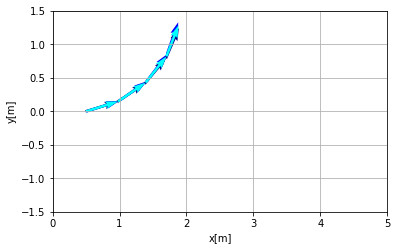

In [8]:
v = Variable(np.array([[.5,.5,.5,.5,.5]],dtype=np.float32))
w = Variable(np.array([[.3,.3,.3,.3,.3]],dtype=np.float32))
z = sim_oplus_nes(v,w)
print(z)
fig, ax = (plt.figure(), plt.axes())
plot_path(ax, z.data[0], color='blue', xlim=[.0, 5.], ylim=[-1.5,1.5])
plot_path(ax, z.data[1], color='darkblue', xlim=[.0, 5.], ylim=[-1.5,1.5])
mz = (z[0] + z[1])/2.
plot_path(ax, mz.data, color='cyan', xlim=[.0, 5.], ylim=[-1.5,1.5])
plt.show()

In [9]:
def Error(xt, x):
    e = F.sum((xt - x)**2)
    return e

xt = np.array([
    [ 0.5,  0, .0],
    [ 1.0, .0, .0],
    [ 1.5, .0, .0],
    [ 2.0, .0, .0],
    [ 2.5, .0, .0]],dtype=np.float32)
e = Error(xt, mz)
print(e)
e.backward()
gv = chainer.grad((e,),(v,))[0]
gw = chainer.grad((e,),(w,))[0]
print(gv)
print(gw)

variable(7.97505)
variable([[ 0.36889046  1.5663872   4.1727066   9.201448   17.788818  ]])
variable([[ 0.4358931  1.8508946  4.9306083 10.872734  21.019854 ]])


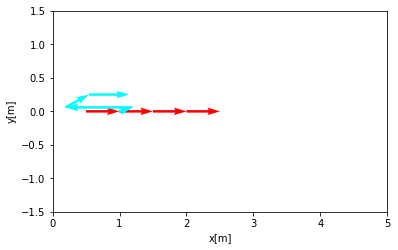

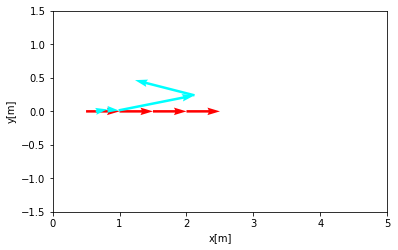

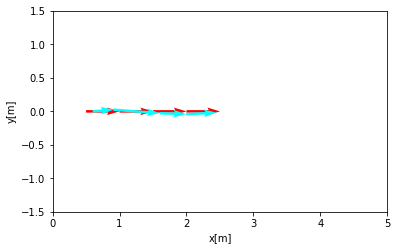

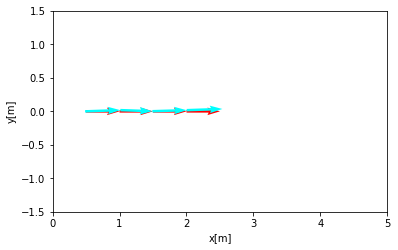

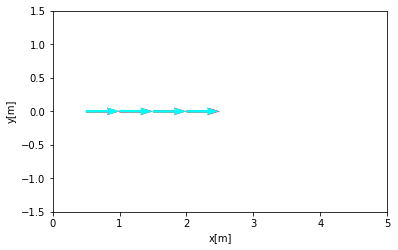

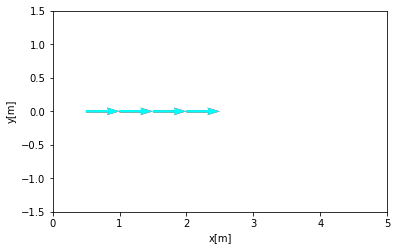

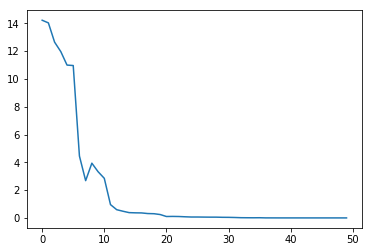

In [10]:
itr = 50
lr = .01
loss = []
xt = np.array([
    [ 0.5,  0, .0],
    [ 1.0, .0, .0],
    [ 1.5, .0, .0],
    [ 2.0, .0, .0],
    [ 2.5, .0, .0]],dtype=np.float32)
v = Variable(np.array([[.5,.1,-.5,.2,.3]],dtype=np.float32))
w = Variable(np.array([[.3,-.3,.5,-.5,1.3]],dtype=np.float32))
for i in range(itr):
    z = sim_oplus_nes(v,w)
    mz = z[0] + z[1]
    e = Error(xt, mz)
    e.backward()
    loss.append(e.data)
    gv = chainer.grad((e,),(v,))[0]
    gw = chainer.grad((e,),(w,))[0]
    v = Variable(v.data - lr*gv.data)
    w = Variable(w.data - lr*gw.data)
    if i % 10 == 0:
        fig, ax = (plt.figure(), plt.axes())
        plot_path(ax, xt, color='red', xlim=[.0, 5.], ylim=[-1.5,1.5])
        plot_path(ax, mz.data, color='cyan', xlim=[.0, 5.], ylim=[-1.5,1.5])
        plt.show()

fig, ax = (plt.figure(), plt.axes())
plot_path(ax, xt, color='red', xlim=[.0, 5.], ylim=[-1.5,1.5])
plot_path(ax, mz.data, color='cyan', xlim=[.0, 5.], ylim=[-1.5,1.5])
plt.show()
plt.plot(range(len(loss)),loss)